# Installing the required libraries

In [23]:
! pip install -r requirements.txt


DEPRECATION: Loading egg at /Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/chainercv-0.13.1-py3.12-macosx-11.1-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## 1.Importing the required libraries

In [2]:
#%%
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from seg_dataset import SegmentationDataset, RandomFlipRotate
import segmentation_models_pytorch as smp 
import seaborn as sns
import matplotlib.pyplot as plt
from segformer_pytorch import Segformer
import torch.nn.functional as F
import os 
import glob
from torchmetrics.classification.jaccard import MulticlassJaccardIndex as jaccard

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from captum.attr import LayerGradCam, LayerAttribution, visualization as viz
from captum.attr import IntegratedGradients, Occlusion

import os
from skimage import exposure
import time

## 2. Training or Fine-Tuning a Semantic Segmentation Model:

- The model introduced here is **SegFormer**:

SegFormer is an efficient and scalable Transformer-based model for semantic segmentation, designed by incorporating both local and global information across multiple feature scales. Unlike traditional CNN-based models, SegFormer leverages the power of Transformers to capture long-range dependencies while remaining computationally efficient, making it highly suitable for large-scale segmentation tasks. SegFormer achieves this through a hierarchical Transformer encoder that outputs multi-scale feature maps, followed by a lightweight decoder that aggregates these features to produce precise segmentation maps. The model is well-regarded for its strong performance across diverse datasets and applications without the need for complex decoder architectures.

For more detailed information, refer to the [SegFormer paper](https://arxiv.org/pdf/2105.15203) on arXiv.


#### Defining the Device, number of Epochs and Batch size

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# %%
EPOCHS = 2
BS = 128

## Dataset and DataLoader Setup

In this section, we instantiate the dataset and DataLoader for training and validation.

- **Dataset**: The dataset is initialized using the `SegmentationDataset` class, which takes the `data_path` as an argument to point to the directory containing training or validation images. This dataset is specifically tailored for semantic segmentation tasks, where each image has a corresponding ground truth label for pixel-wise classification.

- **Weighted Sampling (Commented)**: Although not active in this setup, a `WeightedRandomSampler` can be used to address class imbalances in the dataset. This sampling method allows for a balanced representation of each class in every batch by assigning higher sampling probabilities to underrepresented classes.

- **DataLoader**: The `DataLoader` enables efficient loading of data in batches, shuffling, and parallelization (with `pin_memory=True` for faster data transfer to the GPU). The batch size is set using `BS`, allowing the model to process multiple images at once for training or validation. The training and validation DataLoaders are created separately to handle each dataset independently, allowing us to evaluate the model's performance on unseen validation data.


In [4]:
# #%% Instantiate Dataset and Dataloader
train_ds = SegmentationDataset(data_path='/scratch/sebrah13/RS_class/yearlyImage/Train')
# sampler = torch.utils.data.WeightedRandomSampler(train_ds.weights, len(train_ds.weights))
train_dataloader = DataLoader(train_ds, batch_size=BS, pin_memory=True)
val_ds = SegmentationDataset(data_path='/scratch/sebrah13/RS_class/yearlyImage/Val')
# sampler1 = torch.utils.data.WeightedRandomSampler(val_ds.weights, len(val_ds.weights))
val_dataloader = DataLoader(val_ds, batch_size=BS, pin_memory=True)

In [5]:
for DD in val_dataloader:
    print(DD['image'].shape, DD['mask'].shape)
    
    break

torch.Size([128, 8, 64, 64]) torch.Size([128, 64, 64])


## SegFormer Model Configuration

The **SegFormer** model is configured here with specific parameters to optimize its performance for our semantic segmentation task.

- **dims**: `(32, 64, 160, 256)`  
  These are the feature dimensions for each of the four stages of the model. Each stage has a different dimension, allowing the model to learn both low- and high-level features at different resolutions. The values are chosen to be divisible by the respective number of heads in each stage to ensure efficient parallel processing in the multi-head attention layers.

- **heads**: `(1, 2, 5, 8)`  
  The number of attention heads in each stage corresponds to the feature dimensions. By setting different head counts for each stage, we allow each stage to capture different levels of detail, with more heads for the later stages to better focus on finer spatial details.

- **ff_expansion**: `(4, 4, 4, 4)`  
  The feedforward expansion factor for each stage determines the growth of the hidden layer within the feedforward network. An expansion factor of 4 is applied to each stage to provide sufficient capacity for feature extraction without excessive complexity.

- **reduction_ratio**: `(8, 4, 2, 1)`  
  This parameter controls the reduction of spatial dimensions across stages, with larger reductions in early stages to capture global context and less reduction in later stages for detailed, fine-grained spatial features.

- **num_layers**: `(3, 6, 40, 3)`  
  Specifies the number of Transformer layers in each stage, allowing for deeper feature extraction in middle stages (e.g., 40 layers) where most feature complexity arises, while fewer layers in initial and final stages keep the model efficient.

- **channels**: `8`  
  The number of input channels in the model, reflecting the multi-spectral input data or other specialized channel configurations used for segmentation.

- **decoder_dim**: `64`  
  Dimension for the decoder, responsible for aggregating and upscaling the multi-scale features generated by the encoder to produce precise segmentation maps.

- **num_classes**: `9`  
  The number of output segmentation classes, aligning with the specific categories we aim to classify within our segmentation task.

These parameters are optimized for effective segmentation performance, balancing model complexity and computational efficiency, especially suitable for tasks with diverse input channels and high class variability.


In [6]:

model = Segformer(
    dims = (32, 64, 160, 256),     # Adjusted to ensure divisibility by the number of heads
    heads = (1, 2, 5, 8),           # Keep heads as they divide the corresponding dimensions correctly
    ff_expansion = (4, 4, 4, 4),    # Feedforward expansion factor of each stage
    reduction_ratio = (8, 4, 2, 1), # Reduction ratio for each stage for efficient attention
    num_layers = (3, 6, 40, 3),     # Number of layers in each stage
    channels = 8,                  # Number of input channels
    decoder_dim = 64,               # Decoder dimension
    num_classes = 9                 # Number of segmentation classes
)
model.to(DEVICE)    

#### Initializing the Optimizer

#### Loading weights in case of fine tunning
#### Intersection over Union (IoU) Metric

In this setup, we use **Intersection over Union (IoU)**, also known as the Jaccard Index, as a metric to evaluate segmentation model performance. This metric measures the overlap between the predicted and ground truth segmentation classes, providing insight into how accurately the model distinguishes each class in the image.

- **Formula**:
 

$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|}
$$

where \( A \) is the set of pixels for a predicted class, and \( B \) is the set of pixels for the corresponding ground truth class. Here, \( |A \cap B| \) represents the number of pixels that are correctly classified (intersection), and \( |A \cup B| \) is the total number of pixels for both predicted and actual classes (union).



- **Parameters**:
  - `num_classes=9`: This argument specifies that the dataset contains 9 classes, so the IoU will be calculated individually for each class.
  - `average='none'`: By setting `average` to `'none'`, IoU values are computed separately for each class instead of averaging them, which helps in understanding the model's performance per class.
  - `.to(DEVICE)`: The IoU computation is moved to the specified device (e.g., CPU or GPU) to utilize available hardware for faster calculation.

This IoU setup enables detailed performance evaluation across all classes, allowing for fine-grained insights into model strengths and areas for improvement in multi-class segmentation.


In [7]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])



wights = glob.glob("SegFormer*.pth")
if wights:
    model.load_state_dict(torch.load(f'SegFormer_epochs_{EPOCHS}_crossentropy_state_dict.pth'))
    print("Pretrained weights loaded")
else:
    print("No pretrained weights found, intializing random weights...")    
    # %%
criterion = nn.CrossEntropyLoss().to(DEVICE)



IoU = jaccard( num_classes= 9, average='none').to(DEVICE)

train_losses, val_losses = [],[]

No pretrained weights found, intializing random weights...


## 2.1 Start training

In [8]:
Prev_loss = 10000
min_loss = 10000
for e in range(EPOCHS):
    model.train()
    running_train_loss, running_val_loss = 0, 0
    metrics = {'iou_scores': [], 'f1_scores': [], 'f2_scores': [], 'accuracies': [], 'recalls': [], 'ious': [], 'losses': []}
    for i, data in enumerate(train_dataloader):
        #training phase
        image_i, mask_i = data['image'], data['mask']
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)
        
        # reset gradients
        optimizer.zero_grad() 
        #forward
        output = model(image.float())
        # Upsample the output to match the target label size
        # output_upsampled = output
        output_upsampled =F.interpolate(output, size=mask.shape[1:], mode = 'bilinear',   align_corners=False)
        # calc losses
        train_loss = criterion(output_upsampled .float(), mask.long())

        # back propagation
        train_loss.backward()
        optimizer.step() #update weight          
        running_train_loss += train_loss.item()
        
        # adding metrics
        IoU_metric = IoU(output_upsampled .float(), mask.long())
        _, pred = torch.max(output_upsampled, 1)
        tp, fp, fn, tn = smp.metrics.get_stats(pred, mask.long(), mode='multiclass', num_classes=9)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        #storing the metrics in a dictionary
        metrics['ious'].append(IoU_metric)
        metrics['iou_scores'].append(iou_score)
        metrics['f1_scores'].append(f1_score)
        metrics['f2_scores'].append(f2_score)
        metrics['accuracies'].append(accuracy)
        metrics['recalls'].append(recall)
        metrics['losses'].append(train_loss.item())
        
    train_losses.append(running_train_loss) 
    
    # Compute mean of each metric
    mean_metrics =  {
    metric: np.mean([v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in values])
    for metric, values in metrics.items()
}
    print(f"Epoch: {e}, Training Mean Loss: {mean_metrics['losses']}, Mean IoU: {mean_metrics['ious']}, "
        f"Mean IoU Score: {mean_metrics['iou_scores']}, Mean F1 Score: {mean_metrics['f1_scores']}, ")
        # f"Mean F2 Score: {mean_metrics['f2_scores']}, Mean Accuracy: {mean_metrics['accuracies']}, "
        # f"Mean Recall: {mean_metrics['recalls']}")
    
    # validation
    model.eval()
    val_metrics = {'iou_scores': [], 'f1_scores': [], 'f2_scores': [], 'accuracies': [], 'recalls': [], 'ious': []}
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            image_i, mask_i = data['image'], data['mask']
            image = image_i.to(DEVICE)
            mask = mask_i.to(DEVICE)
            #forward
            output = model(image.float())
            # output_upsampled = output
            
            output_upsampled = F.interpolate(output, size=mask.shape[1:],mode = 'bilinear', align_corners=False)
            # calc losses
            val_loss = criterion(output_upsampled.float(), mask.long())
            running_val_loss += val_loss.item()
            
            # Calculate additional metrics
            _, pred = torch.max(output_upsampled, 1)
            IoU_metric = IoU(output_upsampled.float(), mask.long())
            tp, fp, fn, tn = smp.metrics.get_stats(pred, mask.long(), mode='multiclass', num_classes=9)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
            # Store metrics in the validation metrics dictionary
            val_metrics['ious'].append(IoU_metric)
            val_metrics['iou_scores'].append(iou_score)
            val_metrics['f1_scores'].append(f1_score)
            val_metrics['f2_scores'].append(f2_score)
            val_metrics['accuracies'].append(accuracy)
            val_metrics['recalls'].append(recall)
            
    val_losses.append(running_val_loss)
    # Compute mean of each metric and loss
    mean_val_metrics = {
    metric: np.mean([v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in values])
    for metric, values in val_metrics.items()
}
    mean_val_loss = np.mean(running_val_loss / len(val_dataloader))
    # Append the average validation loss for this epoch
    # val_losses.append(mean_val_loss)

# Log or print validation metrics and loss
    print(f"Validation Loss: {mean_val_loss}, Mean IoU: {mean_val_metrics['ious']}, "
      f"Mean IoU Score: {mean_val_metrics['iou_scores']}, Mean F1 Score: {mean_val_metrics['f1_scores']}, ")
    #   f"Mean F2 Score: {mean_val_metrics['f2_scores']}, Mean Accuracy: {mean_val_metrics['accuracies']}, "
    #   f"Mean Recall: {mean_val_metrics['recalls']}")
    
    
    
    if np.median(running_val_loss) < min_loss:
        print(f"Loss value improved from {min_loss} to {np.median(running_val_loss)}; Saving model weights...")
        torch.save(model.state_dict(), f'SegFormer_epochs_{EPOCHS}_crossentropy_state_dict.pth')
        Prev_loss = np.median(running_val_loss)
        if min_loss > Prev_loss:
            min_loss = Prev_loss
            
                # Write report to text file
        with open('report.txt', 'a') as file:  # 'a' mode for appending in case this happens multiple times
            file.write(f"Epoch: {e}, Median Validation Loss: {running_train_loss},\n")
            file.write(f"Epoch: {e}, Median Validation Loss: {running_val_loss},\n")
            file.write("Mean Validation Metrics:\n")
            for metric, value in mean_val_metrics.items():
                file.write(f"{metric}: {value}\n")
            file.write("Metrics training Criteria (if any):\n")
            for metric, value in mean_metrics.items():
                file.write(f"{metric}: {value}\n")
           
    print(f"Epoch: {e}: Train Cumulative Loss: {np.median(running_train_loss)}, Val cumulative Loss: {np.median(running_val_loss)} ")


KeyboardInterrupt: 

plotting training and validation loss

In [ ]:
#%% TRAIN LOSS
plt.figure(figsize=(10, 5))  
sns.lineplot(x = range(len(train_losses)), y= train_losses)
sns.lineplot(x = range(len(train_losses)), y= val_losses)

# Adding titles and labels
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()  # Show legend to identify the lines
plt.savefig('trainloss.png')
plt.show()  # Display the plotplt.show()

# 3 .Model Inference

For model inference, we are using a trained **LinkNet** model.

### LinkNet

**LinkNet** is a lightweight neural network architecture optimized for semantic segmentation. It follows an **encoder-decoder** structure, where the encoder captures key features of the input, and the decoder upscales these features back to the original input size for pixel-level classification. LinkNet uses **skip connections** between encoder and decoder stages, enabling it to retain high-resolution spatial details while being computationally efficient. LinkNet is known for its speed, making it ideal for real-time applications where lower computational demands are needed.



### Key Differences Between LinkNet and U-Net

| Feature              | LinkNet                                | U-Net                                  |
|----------------------|----------------------------------------|----------------------------------------|
| **Architecture**     | Encoder-decoder with asymmetric skip connections | Symmetric encoder-decoder with skip connections at each level |
| **Backbone**         | Often uses deep CNN backbones like **ResNet101** for feature extraction | Typically uses smaller, custom CNN layers for both encoder and decoder |
| **Skip Connections** | Limited, placed to optimize efficiency | Extensive, symmetric connections to retain high-resolution features |
| **Efficiency**       | Lightweight and optimized for speed, suitable for real-time applications | More computationally intensive and memory-heavy due to extensive connections |
| **Use Cases**        | Ideal for scenarios requiring faster inference with moderate segmentation precision | Effective for applications needing high accuracy and fine segmentation detail |
| **Application Areas**| Real-time or resource-constrained environments | Biomedical, satellite, and other detailed segmentation tasks requiring high accuracy |

In summary, **LinkNet** is generally preferred for real-time segmentation applications due to its efficiency, while **U-Net** is favored for tasks where high segmentation precision is crucial, although it demands more computational resources. This setup allows LinkNet to provide accurate results at high speed, leveraging ResNet101 for feature-rich encoding.

### ResNet101 Backbone

LinkNet often uses **ResNet101** as its backbone for feature extraction in the encoder. **ResNet101** (Residual Network with 101 layers) is a deep convolutional neural network architecture that employs **residual connections** to overcome the vanishing gradient problem, enabling the training of very deep networks. In ResNet, residual connections allow the network to "skip" layers by adding the input of a layer to its output, forming a shortcut path. This design enables ResNet101 to learn complex features effectively while minimizing degradation in performance as the network depth increases.

The use of ResNet101 in LinkNet leverages its powerful feature extraction capabilities, allowing LinkNet to capture both low-level and high-level features efficiently. This combination of ResNet101’s depth and LinkNet’s efficient upsampling structure makes it a robust choice for precise and efficient semantic segmentation.

In this inference setup, LinkNet with a ResNet101 backbone provides a balance between performance and computational efficiency, making it suitable for generating accurate segmentation maps in real-time applications.

In [9]:
#%% Model setup
model = smp.Linknet(
    encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=8,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=9,                      # model output channels (number of classes in your dataset)
    encoder_depth=5,                # number of encoder backbone stages
    activation = 'softmax'
)

In [10]:
test_dir = '/scratch/sebrah13/RS_class/yearlyImage/Val'
test_ds = SegmentationDataset(data_path=test_dir)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)

model_path = '/scratch/sebrah13/RS_class/LinkNET/LinkNet_epochs_200_crossentropy_state_dict.pth'


## model.eval()

The `model.eval()` function in PyTorch is used to set the model to evaluation (or inference) mode. This is essential when you’re testing or validating a trained model, as it changes the behavior of certain layers to ensure consistent predictions.

### Key Effects of `model.eval()`

- **Disables Dropout**: During training, dropout layers randomly deactivate certain neurons to prevent overfitting by encouraging the model to rely on a wider range of features. However, in evaluation mode, dropout layers are disabled so that all neurons are active, providing stable predictions.
  
- **Batch Normalization**: Batch normalization layers behave differently in training versus evaluation. In training, they calculate the mean and variance of each batch, which can introduce variability. In evaluation mode, batch normalization layers use the learned population statistics (mean and variance) instead, ensuring consistency across different input batches.

### Why Use `model.eval()`?

Using `model.eval()` before inference is crucial because it ensures that layers like dropout and batch normalization are set to their correct modes, making predictions more reliable and consistent. Failing to use `model.eval()` may lead to unexpected results, as the model could still behave as if it were in training mode.

In practice, you’d use `model.eval()` like this:

```python
model.eval()
with torch.no_grad():  # Disables gradient calculation for faster evaluation
    output = model(input_data)


In [11]:
model.eval()
model.to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [8]:
# %% Helper functions to calculate metrics
def calculate_metrics(tp, fp, fn, tn):
    epsilon = 1e-7
    f1 = 2 * tp / (2 * tp + fp + fn + epsilon)
    f2 = 5 * tp / (5 * tp + 4 * fn + fp + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    recall = tp / (tp + fn + epsilon)
    return f1, f2, accuracy, recall

# %% Model Evaluation
num_classes = 9
tp = np.zeros(num_classes)
fp = np.zeros(num_classes)
fn = np.zeros(num_classes)
tn = np.zeros(num_classes)  # Added true negatives

all_true_labels, all_pred_labels = [],[]

with torch.no_grad():
    for data in test_dataloader:
        inputs, outputs = data['image'], data['mask']
        true = outputs.to(torch.float32).to(DEVICE)
        pred = model(inputs.to(DEVICE).float())
        pred = F.interpolate(pred, size=true.shape[1:], mode = 'bilinear',   align_corners=False)
        _, predicted = torch.max(pred, 1)
        
        all_true_labels.extend(true.cpu().numpy().flatten())
        all_pred_labels.extend(predicted.cpu().numpy().flatten())

        for cls in range(num_classes):
            tp[cls] += torch.sum((predicted == cls) & (true == cls)).item()
            fp[cls] += torch.sum((predicted == cls) & (true != cls)).item()
            fn[cls] += torch.sum((predicted != cls) & (true == cls)).item()
            tn[cls] += torch.sum((predicted != cls) & (true != cls)).item()  # Correctly count true negatives

# Compute IoU for each class
class_iou = tp / (tp + fp + fn + 1e-7)
mean_iou = np.mean(class_iou)

# Compute additional metrics
f1_scores, f2_scores, accuracies, recalls = calculate_metrics(tp, fp, fn, tn)
mean_f1 = np.mean(f1_scores)
mean_f2 = np.mean(f2_scores)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)

print(f"Class-wise IoUs: {class_iou}")
print(f"Mean IoU: {mean_iou}")
print(f"Mean F1 Score: {mean_f1}")
print(f"Mean F2 Score: {mean_f2}")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Recall: {mean_recall}")


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


KeyboardInterrupt: 

### Confusion Matrix

In [12]:
#%% Confusion Matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd


Name = 'Linknet'

# Compute confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels, labels=list(range(num_classes)))

# Normalize confusion matrix by row (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert to percentage
conf_matrix_normalized *= 100
# Create a custom colormap
cmap = sns.color_palette("rocket_r", as_cmap=True)
# Plot normalized confusion matrix
plt.figure(figsize=(6, 4.5))
ax = sns.heatmap(pd.DataFrame(conf_matrix_normalized, columns=[f'{i+1}' for i in range(num_classes)], 
                         index=[f'{i+1}' for i in range(num_classes)]), 
            annot=True, fmt='.2f', cmap=cmap, vmin=0, vmax=100)

# Set font properties
plt.xlabel('Predicted', fontsize=14, fontname='Times New Roman')
plt.ylabel('True', fontsize=14, fontname='Times New Roman')
plt.title(f'{Name}'
        #   {config_name[-5:]}'
          , fontsize=18, fontname='Times New Roman')

# Set ticks font properties
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname='Times New Roman')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontname='Times New Roman')

# Adjust color bar font properties
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.ax.set_yticklabels([f'{int(i)}%' for i in colorbar.get_ticks()], fontsize=14, fontname='Times New Roman')

plt.savefig(f'normalized_confusion_matrix{Name}.png')
plt.show()

NameError: name 'all_true_labels' is not defined

### visualizing some of the images

/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


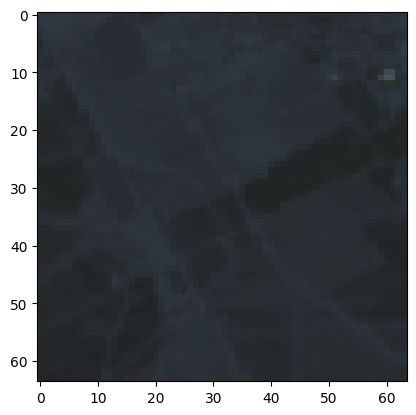

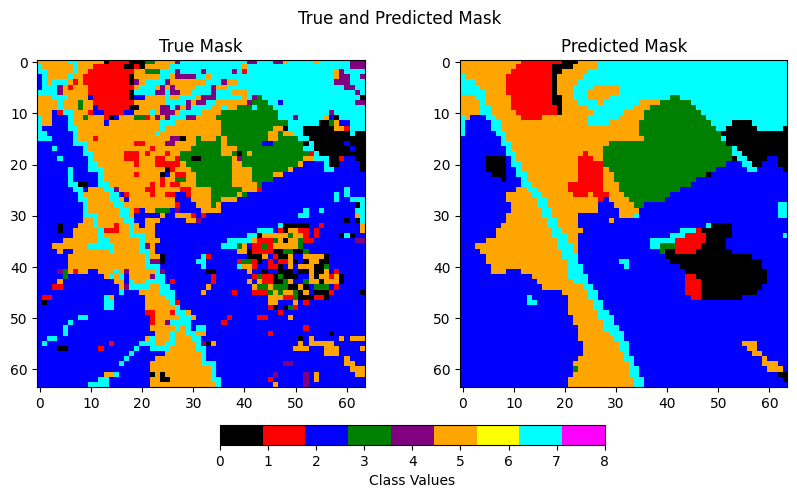

[0 1 2 3 5 7]
[0. 1. 2. 3. 4. 5. 7.]


In [13]:
#%% Pick a test image and show it
from matplotlib.colors import ListedColormap
Sample = next(iter(test_dataloader))
image_test, mask = Sample['image'], Sample['mask']
plt.imshow(np.transpose(image_test[0, 0:3, :, :].cpu().numpy(), (1, 2, 0)))

#%% EVALUATE MODEL
# create preds
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

#%%
output_cpu = output.cpu().squeeze().numpy()
Output = output_cpu[:,:,:]
output_cpu = Output.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)

# %%



# Define a color map with 9 distinct colors for values 0 to 8
colors = ['black', 'red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']
cmap = ListedColormap(colors)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('True and Predicted Mask')

true_mask_img = axs[0].imshow(mask[0, :, :], cmap=cmap, vmin=0, vmax=8)
predicted_mask_img = axs[1].imshow(output_cpu, cmap=cmap, vmin=0, vmax=8)

# Add titles
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")

# Add color bar to interpret the values
fig.colorbar(true_mask_img, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1, label='Class Values')

# Save and display the plot
plt.savefig('Predicted_Mask.png')
plt.show()

# %%
print(np.unique(output_cpu))
print(np.unique(mask[0, :, :].numpy()))

## Model Explainability Methods: Occlusion, Integrated Gradients, and Grad-CAM

Understanding the decision-making process of complex models like deep neural networks is essential, especially in tasks like semantic segmentation. Here, we explore three popular explainability methods: **Occlusion**, **Integrated Gradients**, and **Grad-CAM**, each offering unique insights into model predictions.

### 1. Occlusion

**Occlusion** involves masking parts of the input and observing changes in the model's output to assess the importance of each region. By systematically occluding different areas, we can quantify each region's contribution to the final prediction. For example, if masking a particular part of an image significantly changes the output, that region is likely important in the model’s decision.

- **Procedure**: A sliding window occludes portions of the input (e.g., pixels or patches) while recording the change in model predictions.
- **Formula**:
  
  $$
  \text{Importance} = f(\text{input}) - f(\text{input with occluded region})
  $$
  
  where \( f(\text{input}) \) is the model’s output with the complete input, and \( f(\text{input with occluded region}) \) is the output with a specific region occluded.

For more details, refer to [Zeiler and Fergus, Visualizing and Understanding Convolutional Networks (2014)](https://arxiv.org/abs/1311.2901).

### 2. Integrated Gradients

**Integrated Gradients (IG)** attributes the prediction to the input features by integrating gradients along a path from a baseline (e.g., a blank or black image) to the actual input. This approach considers the accumulated contributions along a continuous path, offering a more complete perspective than standard gradients.

- **Formula**:
  
  $$
  \text{IG}(x_i) = (x_i - x_i') \times \int_{\alpha=0}^1 \frac{\partial f(x' + \alpha \times (x - x'))}{\partial x_i} \, d\alpha
  $$

  where:
  - \( x \) is the actual input,
  - \( x' \) is the baseline input,
  - \( \alpha \) scales the input from the baseline to the actual input, and
  - \( \frac{\partial f}{\partial x_i} \) is the gradient of the model’s output with respect to the \( i \)-th feature.

For more information, see [Sundararajan et al., Axiomatic Attribution for Deep Networks (2017)](https://arxiv.org/abs/1703.01365).

### 3. Grad-CAM (Gradient-weighted Class Activation Mapping)

**Grad-CAM** is a popular method for visualizing the regions in the input that most strongly influence the model’s output for a particular class. It works by using the gradients of the target class with respect to the feature maps in the final convolutional layers. Grad-CAM highlights the areas most influential to the model’s prediction, making it easier to interpret decisions.

- **Formula**:
  
  $$
  L_{\text{Grad-CAM}}^c = \text{ReLU} \left( \sum_k \alpha_k^c A^k \right)
  $$
  
  where:
  - \( A^k \) is the \( k \)-th feature map from the last convolutional layer,
  - \( \alpha_k^c = \frac{1}{Z} \sum_{i,j} \frac{\partial y^c}{\partial A_{ij}^k} \) is the weight for each feature map, computed as the average of gradients with respect to the class score \( y^c \),
  - \( Z \) is a normalization factor (e.g., the number of pixels in the feature map),
  - \( \text{ReLU} \) ensures that only positive influences are considered.

For more details, refer to [Selvaraju et al., Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization (2017)](https://arxiv.org/abs/1610.02391).

These techniques—Occlusion, Integrated Gradients, and Grad-CAM—offer complementary views of model interpretability, aiding in a better understanding of deep learning models’ decision-making processes.


In [27]:


# Define a wrapper function to aggregate outputs for GradCAM
def agg_segmentation_wrapper(inputs, target_class):
    model_output = model(inputs)
    target_class = int(target_class)
    # Sum the outputs over the spatial dimensions to get a scalar value
    target_output = model_output[:, target_class, :, :].sum().unsqueeze(0)
    return target_output

# Define a forward function for Integrated Gradients and Occlusion
def ig_occlusion_forward_func(inputs):
    model_output = model(inputs)
    # Return the mean value of the probabilities for all classes
    return model_output.mean(dim=[2, 3])

# Identify the last convolutional layer
def find_last_conv_layer(model):
    layers = list(model.named_modules())
    for name, layer in reversed(layers):
        if isinstance(layer, torch.nn.Conv2d):
            return name, layer
    raise ValueError("No Conv2d layer found in the model")



# Define color maps for visualizations
integrated_gradients_cmap = LinearSegmentedColormap.from_list('white_to_dark', ['white', 'black'])
occlusion_cmap = LinearSegmentedColormap.from_list('white_to_dark_green', ['white', 'darkgreen'])

# Custom normalization function
def normalize_attr(attr):
    min_val = torch.min(attr)
    max_val = torch.max(attr)
    if max_val - min_val != 0:
        attr = (attr - min_val) / (max_val - min_val)
    else:
        attr = attr - min_val
    return attr



In [32]:
# Pick a test image
sample = next(iter(test_dataloader))
image_test, mask = sample['image'], sample['mask']
print(f"Test image shape: {image_test.shape}")

target_layer_name, target_layer = find_last_conv_layer(model)
print(f"Using target layer: {target_layer_name}")

# Perform forward pass to get model output
with torch.no_grad():
    model_output = model(image_test.to(DEVICE).float())

# Get the class index with the highest score for each pixel
out_max = torch.argmax(model_output, dim=1, keepdim=True)
print(f"Model output shape: {model_output.shape}")
print(f"Out_max shape: {out_max.shape}")

Test image shape: torch.Size([1, 8, 64, 64])
Using target layer: segmentation_head.0
Model output shape: torch.Size([1, 9, 64, 64])
Out_max shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Unique classes in ground truth and prediction: [0. 1. 2. 4. 5. 6. 7.]


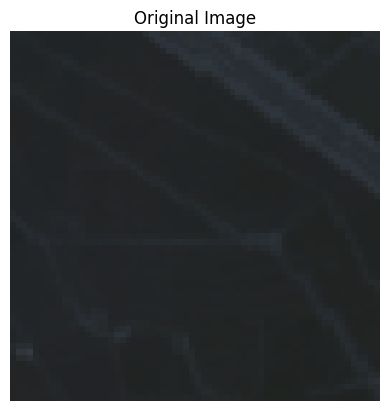

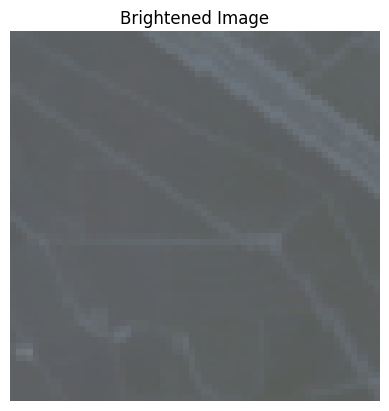

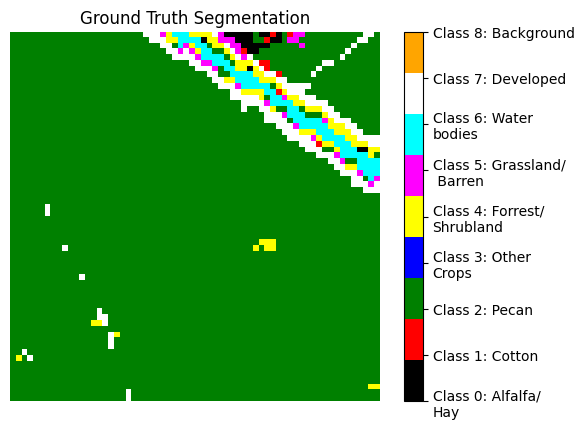

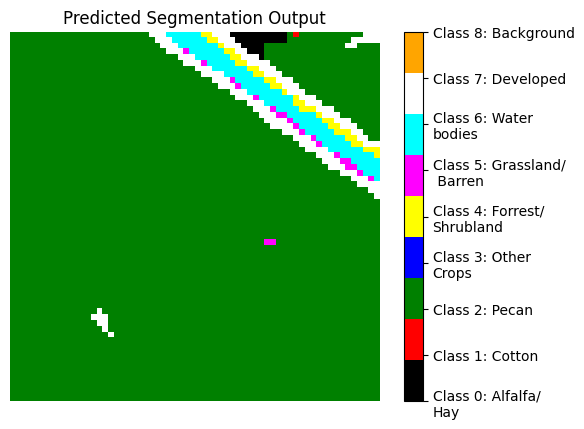

In [33]:

# Identify unique classes in the ground truth and predicted output
unique_classes_gt = torch.unique(mask).cpu().numpy()
unique_classes_pred = torch.unique(out_max).cpu().numpy()
unique_classes = np.union1d(unique_classes_gt, unique_classes_pred)
print(f"Unique classes in ground truth and prediction: {unique_classes}")

# Create output directory for saving plots
output_dir = 'gradcam_plots'
os.makedirs(output_dir, exist_ok=True)

# Define a colormap and labels for the segmentation output
cmap = ListedColormap(['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'white', 'orange'])
labels = ['Class 0: Alfalfa/\nHay', 'Class 1: Cotton ', 'Class 2: Pecan', 'Class 3: Other\nCrops', 'Class 4: Forrest/\nShrubland', 'Class 5: Grassland/\n Barren', 'Class 6: Water\nbodies', 'Class 7: Developed', 'Class 8: Background']

# Visualize the original image and save the plot
# Function to apply gamma correction using skimage
def adjust_gamma(image, gamma=1.0):
    return exposure.adjust_gamma(image, gamma)

# Assuming 'image_test' is your tensor
image_np = np.transpose(image_test[0, 0:3, :, :].cpu().numpy(), (1, 2, 0))

# Adjust gamma to increase brightness
gamma_value = 0.5  # Less than 1 to increase brightness
bright_image = adjust_gamma(image_np, gamma=gamma_value)

# Plot and save the original image
plt.imshow(image_np)
plt.axis('off')
plt.title('Original Image')
plt.savefig(os.path.join(output_dir, 'original_image.png'), bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Plot and save the brightened image
plt.imshow(bright_image)
plt.axis('off')
plt.title('Brightened Image')
plt.savefig(os.path.join(output_dir, 'Input_image.png'), bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Visualize the ground truth segmentation and save the plot
mask_np = mask[0].cpu().numpy().squeeze()
plt.imshow(mask_np, cmap=cmap, vmin=0, vmax=8)  # Using the same colormap to distinguish classes
cbar = plt.colorbar(ticks=np.arange(len(labels)))
cbar.ax.set_yticklabels(labels)
plt.axis('off')
plt.title('Ground Truth Segmentation')
# plt.savefig(os.path.join(output_dir, 'ground_truth_CDL.png'), bbox_inches='tight', pad_inches=0)
plt.show()

plt.close()

# Visualize the predicted segmentation output with color bar and save the plot
out_image = out_max[0].cpu().numpy().squeeze()
plt.imshow(out_image, cmap=cmap, vmin=0, vmax=8)  # Using the same colormap to distinguish classes
cbar = plt.colorbar(ticks=np.arange(len(labels)))
cbar.ax.set_yticklabels(labels)
plt.axis('off')
plt.title('Predicted Segmentation Output')
# plt.savefig(os.path.join(output_dir, 'segmentation_output.png'), bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


Visualizing GradCAM, Integrated Gradients, and Occlusion for class: 0.0
GradCAM attribution shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ig attribution shape: torch.Size([1, 8, 64, 64])
occlusion attribution shape: torch.Size([1, 8, 64, 64])


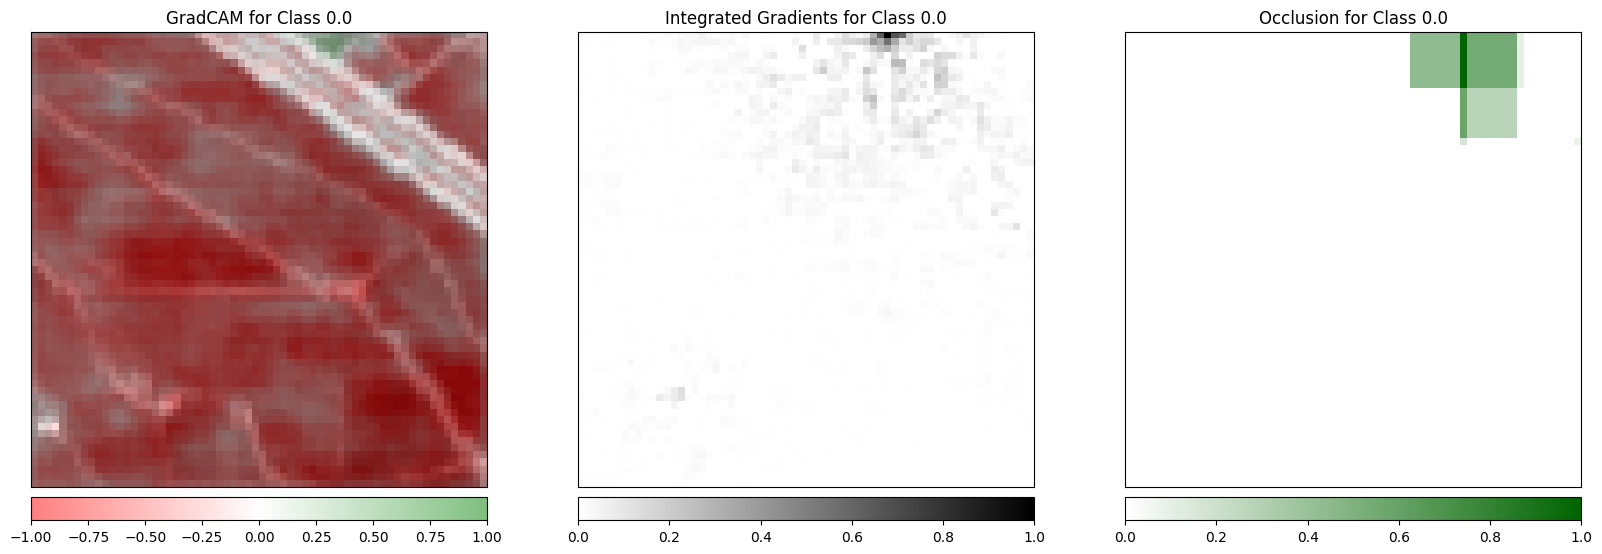

Visualizing GradCAM, Integrated Gradients, and Occlusion for class: 1.0
GradCAM attribution shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ig attribution shape: torch.Size([1, 8, 64, 64])
occlusion attribution shape: torch.Size([1, 8, 64, 64])
Normalization error for class 1.0, applying custom normalization.
Visualizing GradCAM, Integrated Gradients, and Occlusion for class: 2.0
GradCAM attribution shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ig attribution shape: torch.Size([1, 8, 64, 64])
occlusion attribution shape: torch.Size([1, 8, 64, 64])


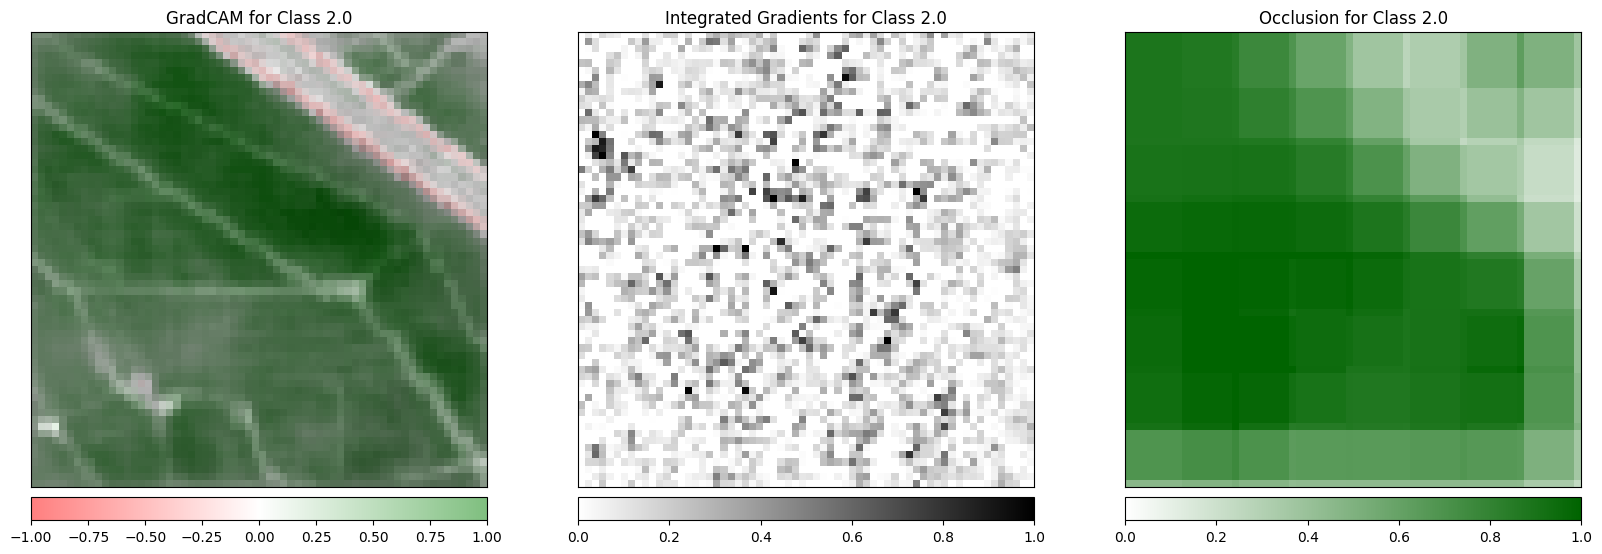

Visualizing GradCAM, Integrated Gradients, and Occlusion for class: 4.0
GradCAM attribution shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ig attribution shape: torch.Size([1, 8, 64, 64])
occlusion attribution shape: torch.Size([1, 8, 64, 64])
Normalization error for class 4.0, applying custom normalization.
Visualizing GradCAM, Integrated Gradients, and Occlusion for class: 5.0
GradCAM attribution shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ig attribution shape: torch.Size([1, 8, 64, 64])
occlusion attribution shape: torch.Size([1, 8, 64, 64])


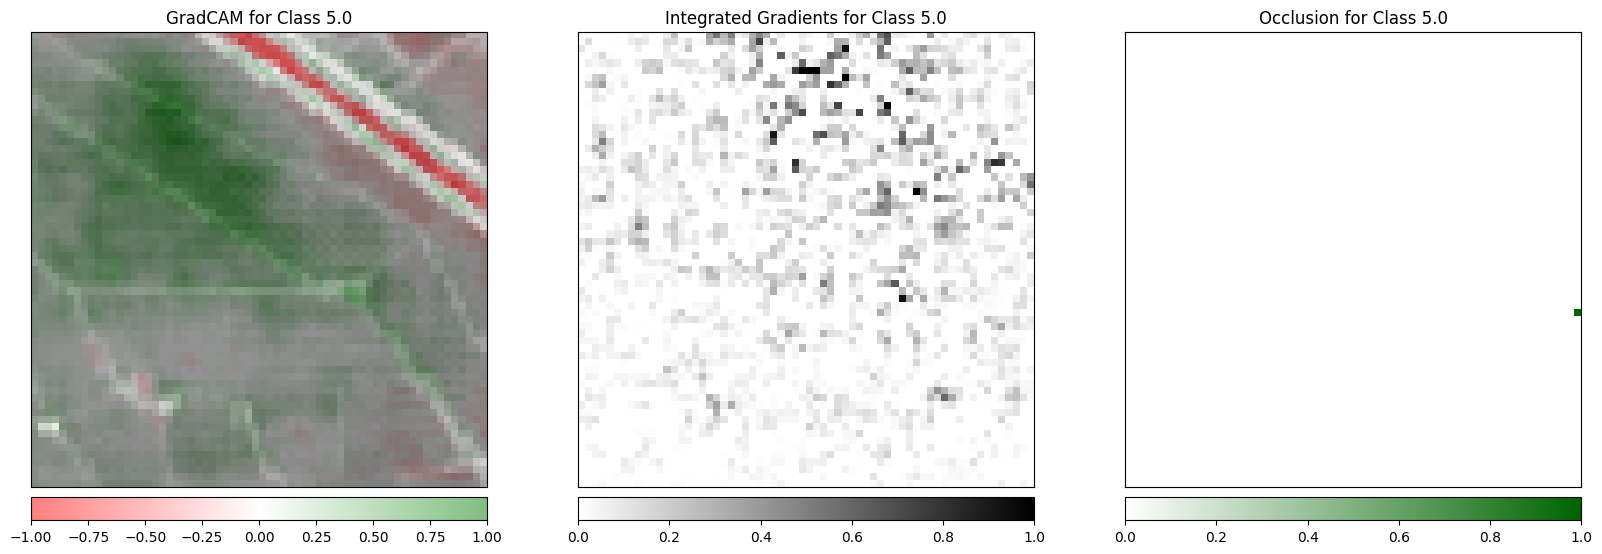

Visualizing GradCAM, Integrated Gradients, and Occlusion for class: 6.0
GradCAM attribution shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ig attribution shape: torch.Size([1, 8, 64, 64])
occlusion attribution shape: torch.Size([1, 8, 64, 64])


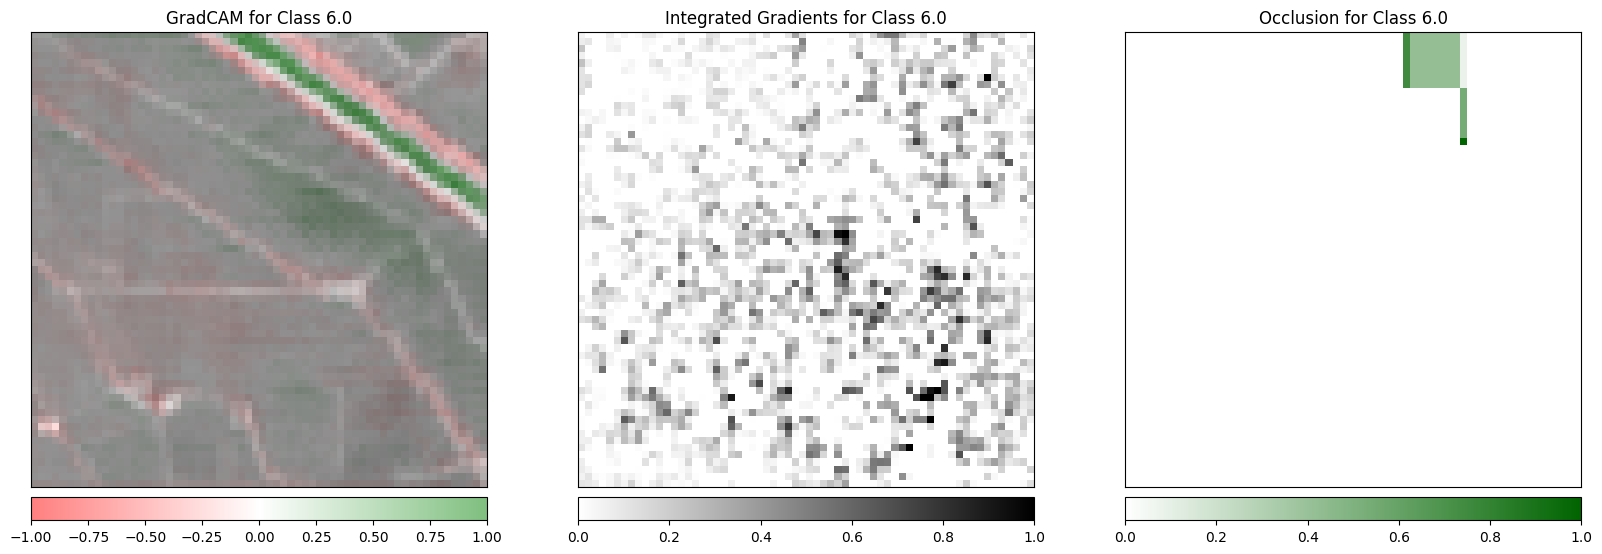

Visualizing GradCAM, Integrated Gradients, and Occlusion for class: 7.0
GradCAM attribution shape: torch.Size([1, 1, 64, 64])


/Users/sebrah13/anaconda3/envs/torch_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


ig attribution shape: torch.Size([1, 8, 64, 64])
occlusion attribution shape: torch.Size([1, 8, 64, 64])


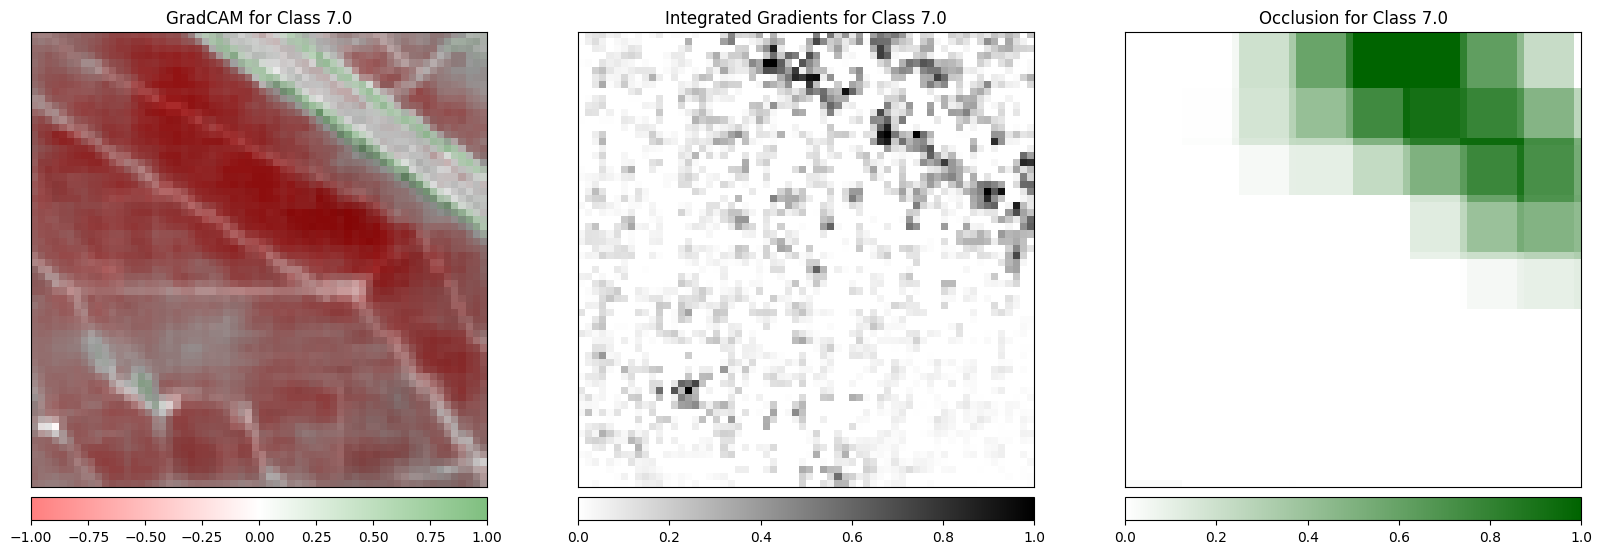

In [34]:
# Compute and visualize GradCAM, Integrated Gradients, and Occlusion for each unique class
for target_class in unique_classes:
    print(f"Visualizing GradCAM, Integrated Gradients, and Occlusion for class: {target_class}")
    
    # GradCAM
    lgc = LayerGradCam(lambda inputs: agg_segmentation_wrapper(inputs, target_class), target_layer)
    gc_attr = lgc.attribute(image_test.to(DEVICE))
    upsampled_gc_attr = LayerAttribution.interpolate(gc_attr, image_test.shape[2:])
    
    print('GradCAM attribution shape:', upsampled_gc_attr.shape)
    
    
    # Integrated Gradients
    ig = IntegratedGradients(ig_occlusion_forward_func)
    ig_attr = ig.attribute(image_test.to(DEVICE), target=int(target_class), n_steps=200)
    print('ig attribution shape:', ig_attr.shape)
    # Occlusion
    occlusion = Occlusion(ig_occlusion_forward_func)
    occlusion_attr = occlusion.attribute(image_test.to(DEVICE), strides=(3, 8, 8), target=int(target_class), sliding_window_shapes=(3, 15, 15), baselines=0)
    print('occlusion attribution shape:', occlusion_attr.shape)
    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    try:
        # GradCAM Visualization
        viz.visualize_image_attr(upsampled_gc_attr[0].cpu().permute(1, 2, 0).detach().numpy(),
                                 original_image=image_np,
                                 sign="all",
                                 method="blended_heat_map",
                                 plt_fig_axis=(fig, axes[0]),
                                 show_colorbar=True,
                                 title=f'GradCAM for Class {target_class}',
                                 use_pyplot=False)
        
        # Integrated Gradients Visualization
        viz.visualize_image_attr(ig_attr[0].cpu().permute(1, 2, 0).detach().numpy(),
                                 original_image=image_np,
                                 sign="positive",
                                 method="heat_map",
                                 cmap=integrated_gradients_cmap,
                                 plt_fig_axis=(fig, axes[1]),
                                 show_colorbar=True,
                                 title=f'Integrated Gradients for Class {target_class}',
                                 use_pyplot=False)
        
        # Occlusion Visualization
        viz.visualize_image_attr(occlusion_attr[0].cpu().permute(1, 2, 0).detach().numpy(),
                                 original_image=image_np,
                                 sign="positive",
                                 method="heat_map",
                                 cmap=occlusion_cmap,
                                 plt_fig_axis=(fig, axes[2]),
                                 show_colorbar=True,
                                 title=f'Occlusion for Class {target_class}',
                                 use_pyplot=True)

    except AssertionError as e:
        if "scale factor = 0" in str(e):
            print(f"Normalization error for class {target_class}, applying custom normalization.")
            occlusion_attr = normalize_attr(occlusion_attr)
            viz.visualize_image_attr(occlusion_attr[0].cpu().permute(1, 2, 0).detach().numpy(),
                                     original_image=image_np,
                                     sign="positive",
                                     method="heat_map",
                                     cmap=occlusion_cmap,
                                     plt_fig_axis=(fig, axes[2]),
                                     show_colorbar=True,
                                     title=f'Occlusion for Class {target_class} (normalized)',
                                     use_pyplot=False)
        else:
            raise e
    
    # Save the figure
    plt.savefig(os.path.join(output_dir, f'interpretability_class_{target_class}.png'), bbox_inches='tight', pad_inches=0)
    plt.close()